# KELM with PCA

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from TfELM.Resources.Kernel import Kernel, CombinedProductKernel, CombinedSumKernel
from TfELM.Layers.KELMLayer import KELMLayer
from TfELM.Models.KELMModel import KELMModel

from alzheption.utils import custom_cross_val_score
from alzheption.clahe import Clahe
from alzheption.extractor import AlzheptionExtractor
from alzheption.classificator import AlzheptionClassificator

2025-03-02 15:00:49.521336: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 15:00:49.824615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740902449.954642   18152 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740902450.000485   18152 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 15:00:50.280439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
alex_1 = AlzheptionExtractor.load_extractor(
    filepath="result/AlzheptionExtractor_OriginalTransformation.pkl", 
    path_dataset_new="../../asset/dataset_jpg_brightness_balance/",
)

alex_1.train_features.__len__(), alex_1.test_features.__len__()

(456, 114)

In [4]:
alex_1.dataset

Dataset ImageFolder
    Number of datapoints: 570
    Root location: ../../asset/dataset_jpg_brightness_balance/

In [5]:
alex_1.dataset[0]

(<PIL.Image.Image image mode=RGB size=256x256>, 0)

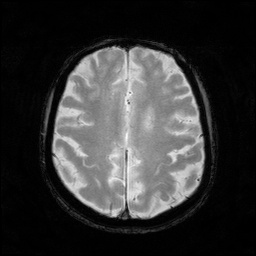

In [6]:
alex_1.dataset[0][0]

In [7]:
alex_1.view_train_label_distribution()

,label,count
0,0,77
1,1,75
2,2,83
3,3,80
4,4,72
5,5,69


In [8]:
alex_1.view_test_label_distribution()

,label,count
0,0,18
1,1,20
2,2,12
3,3,15
4,4,23
5,5,26


In [9]:
alex_1.balance_feature()

In [10]:
alex_1.view_train_label_distribution()

,label,count
0,0,69
1,1,69
2,2,69
3,3,69
4,4,69
5,5,69


In [12]:
alex_1.view_test_label_distribution()

,label,count
0,0,12
1,1,12
2,2,12
3,3,12
4,4,12
5,5,12


In [13]:
pca = PCA(n_components=min(100, *alex_1.train_features.shape))
train_features = pca.fit_transform(alex_1.train_features)
test_features = pca.transform(alex_1.test_features)

train_features.shape, alex_1.train_labels.__len__()

((414, 100), 414)

In [35]:
list_kernel = [
    Kernel("rbf"),
    Kernel("laplacian"),
    Kernel("sigmoid"),
    Kernel("exponential"),
    Kernel("cosine"),
    Kernel("morlet_wavelet"),
    Kernel("mexican_hat_wavelet"),
    Kernel("haar_wavelet"),
    Kernel("rational_quadratic"),
]

list_activation = [
    # "identity",
    "sigmoid",
    "tanh",
    "relu",
    "leaky_relu",
    # "prelu",
    # "elu",
    # "softplus",
    # "bent_identity",
    # "gaussian",
    # "sinusoidal",
    # "isru",
    # "isrlu",
    # "selu",
    # "softmax",
    # "ssigmoid",
    "silu",
    # "gelu",
    # "log",
    # "cube",
    # "inverse",
    # "swish",
    "mish",
    # "bis",
    # "gompertz",
    # "elliott",
    # "isq",
    # "hardshrink",
    # "softshrink",
    # "sqrelu",
    # "sine",
    # "softexp",
    # "arctan",
    # "sin_transfer",
    # "hsigmoid",
    # "tsigmoid",
    # "arcsinh",
    # "logit",
    # "tlu",
    # "aq",
    # "logsigmoid",
    # "cosine",
    # "relu_cos",
    # "imq",
    # "cos_sigmoid",
    # "triangular",
    # "hardtanh",
    # "inverse_sine",
    # "bezier",
    # "bsigmoid",
    # "power",
    # "gswish",
    # "invgamma",
    # "softclip",
    # "inverse_cosine",
    # "sinusoid",
    # "inv_logit",
    # "soft_exponential",
    # "srelu",
    # "inverse_tangent",
    # "hswish",
    # "aqrelu",
    # "gelu2",
    # "sinusoid2",
    # "inverse_tanh",
    # "leaky_softplus",
    # "gaussian_tangent",
    # "exp_cosine",
    # "gaussian_cdf",
    # "hmish",
    # "smooth_sigmoid",
    # "log_exp",
    # "cubic",
    # "exp_sine",
    # "sym_sigmoid",
    # "square",
    # "soft_clipping",
    # "swish_gaussian",
    # "hard_shrink",
    # "smooth_hard_tanh",
    # "bipolar_sigmoid",
    # "log_sigmoid",
    # "hard_sigmoid",
    # "invsqrt",
    # "gauss_tanh",
    # "egaulu",
    # "logarithm",
    # "inv_sine",
    # "hard_tanh",
    # "bent_identity_smoothed",
    # "pos_softplus",
    # "inv_multiquadratic",
    # "inv_cosine",
    # "asymmetric_gaussian",
    # "inv_quadratic",
    # "gaussian_squared",
    # "symmetric_sigmoid",
    # "inv_cubic",
    # "cauchy",
    # "exponential_quadratic",
    # "rational_quadratic",
    # "cubic_spline",
    # "symmetric_soft_clipping",
    # "binary_step",
    # "imrbf",
    # "cloglog",
    # "nrelu",
]

list_layer = [
    {
        "kernel_name": kernel.kernel_name,
        "kernel_param": kernel.kernel_param,
        "activation_name": activation,
        "layer": KELMLayer(kernel, activation)
    } for kernel in list_kernel for activation in list_activation
]

list_model = [
    {
        **layer,
        "model": KELMModel(layer.get("layer")),
    } for layer in list_layer
]

len(list_model)

54

In [15]:
list_model[-7]

{'kernel_name': 'rational_quadratic',
 'kernel_param': 1.0,
 'activation_name': 'rational_quadratic',
 'layer': <TfELM.Layers.KELMLayer.KELMLayer at 0x722299680830>,
 'model': KELMModel(kelm=<TfELM.Layers.KELMLayer.KELMLayer object at 0x722299680830>)}

In [16]:
# Cross Validation Param:
n_splits = 5
n_repeats = 5

In [17]:
alcl = AlzheptionClassificator(alex_1, list_model, n_splits=n_splits, n_repeats=n_repeats)

In [18]:
data = alcl.evaluate_with_cross_validation(n_components=100)

Evaluation: 100%|██████████| 963/963 [13:41<00:00,  1.17it/s]


In [19]:
alcl.df_evaluation.to_parquet("result/TrainKELM_OriginalTransformation.parquet", index=False)

In [34]:
alcl.df_evaluation.sort_values(by=["score_mean"])

,kernel_name,kernel_param,activation_name,score_list,score_mean
743,mexican_hat_wavelet,1.0,cubic_spline,"[0.07142857142857142, 0.0, 0.07216494845360824...",0.048559
742,mexican_hat_wavelet,1.0,rational_quadratic,"[0.07142857142857142, 0.0, 0.07216494845360824...",0.048559
741,mexican_hat_wavelet,1.0,exponential_quadratic,"[0.07142857142857142, 0.0, 0.07216494845360824...",0.048559
740,mexican_hat_wavelet,1.0,cauchy,"[0.07142857142857142, 0.0, 0.07216494845360824...",0.048559
739,mexican_hat_wavelet,1.0,inv_cubic,"[0.07142857142857142, 0.0, 0.07216494845360824...",0.048559
...,...,...,...,...,...
210,laplacian,1.0,binary_step,"[0.6122448979591837, 0.6185567010309279, 0.536...",0.607827
186,laplacian,1.0,smooth_hard_tanh,"[0.6122448979591837, 0.6185567010309279, 0.536...",0.607827
203,laplacian,1.0,symmetric_sigmoid,"[0.6122448979591837, 0.6185567010309279, 0.536...",0.607827
184,laplacian,1.0,swish_gaussian,"[0.6122448979591837, 0.6185567010309279, 0.536...",0.607827


In [28]:
alcl.df_evaluation.sort_values(by=["score_mean"]).tail(1).index.item()

185

In [30]:
alcl.hyperparameter[185]

{'kernel_name': 'laplacian',
 'kernel_param': 1.0,
 'activation_name': 'hard_shrink',
 'layer': <TfELM.Layers.KELMLayer.KELMLayer at 0x7222996703b0>,
 'model': KELMModel(kelm=<TfELM.Layers.KELMLayer.KELMLayer object at 0x7222996703b0>)}

In [36]:
model = alcl.hyperparameter[185].get("model")

In [37]:
# Train KELM on the extracted training features
model.fit(train_features, alex_1.train_labels)

In [38]:
# Evaluate the KELM model on the test set
predictions = model.predict(train_features).numpy()
accuracy = accuracy_score(predictions, alex_1.train_labels)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 1.0000


In [40]:
# Evaluate the KELM model on the test set
predictions = model.predict(test_features).numpy()
accuracy = accuracy_score(predictions, alex_1.test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5556
